In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import time
from Model import Residual_Unit
from Model import Attention_Block
from Model import AttentionResNet56

In [6]:
print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

TF version:  2.0.0
Keras version: 2.2.4-tf


In [7]:
from IPython.display import SVG
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## cifar10 data

In [8]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [9]:
x_train = x_train[:1000, :, :, :]
y_train = y_train[:1000]
x_test = x_test[:200, :, :, :]
y_test = y_test[:200]

# Input image dimensions.
input_shape = x_train.shape[1:]
print('input image shape:', input_shape)

# resize image
start = time.time()

temp = []
for i in range(1000):
    temp.append(skimage.transform.resize(x_train[i,:,:,:], (224, 224), mode='constant'))
    
x_train = np.array(temp).reshape((-1, 224, 224, 3))
    
temp = []
for i in range(200):
    temp.append(skimage.transform.resize(x_test[i,:,:,:], (224, 224), mode='constant'))
    
x_test = np.array(temp).reshape((-1, 224, 224, 3))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))
    
# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(x_train, axis=0)
mean_image_test = np.mean(x_test, axis=0)

x_train = x_train.astype('float32') - mean_image.astype('float32')
x_test = x_test.astype('float32') - mean_image_test

x_train = x_train / 255
x_test = x_test / 255

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

input image shape: (32, 32, 3)
Time taken by above cell is 0.11262774467468262.
x_train shape: (1000, 224, 224, 3)
y_train shape: (1000, 1)
x_test shape: (200, 224, 224, 3)
y_test shape: (200, 1)


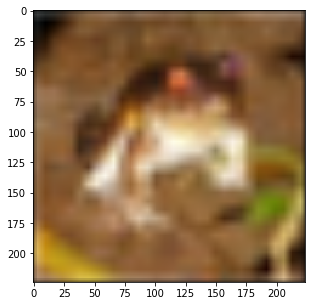

In [7]:
fig = plt.figure(figsize=(5,5))

plt.imshow(x_train[0,:,:,:])
plt.show()

In [10]:
# define generators for training and validation data
train_datagen = ImageDataGenerator()
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rescale = 1/255)
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

val_datagen = ImageDataGenerator()
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rescale = 1/255)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(x_train)
val_datagen.fit(x_train)

In [12]:
# build a model
model = AttentionResNet56(shape=(224,224,3), in_channel=64, kernel_size=7, n_classes=10, regularization=0.01)

# define loss, metrics, optimizer
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 112, 112, 64) 256         conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 112, 112, 64) 0           batch_normalization_82[0][0]     
____________________________________________________________________________________________

In [14]:
batch_size = 32
epc = 30

start = time.time()

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
step_size_train = train_generator.n // train_generator.batch_size
test_generator = val_datagen.flow(x_test, y_test, batch_size=batch_size)
step_size_test = test_generator.n // test_generator.batch_size

model.fit_generator(train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = epc,
                    validation_data = test_generator,
                    validation_steps = step_size_test)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Epoch 1/30


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

## Zhaoyang

In [ ]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()
print(model_type)


# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])